In [1]:
import gizmo_analysis as gizmo
import matplotlib.pyplot as plt
from matplotlib import colors
import asdf
import numpy as np

plt.rcParams.update({"font.family": "serif"})

loading data

In [2]:
sim_name = "m12f_res7100"
af = asdf.open(f'{sim_name[:4]}_symmetry_axes.asdf')

af.info()

In [3]:
r = af["radius"]
L = af["angular.momentum"]
min_axs = np.array([af["symmetry.axes"][i][2] for i in range(len(af["symmetry.axes"]))])
maj_axs = np.array([af["symmetry.axes"][i][0] for i in range(len(af["symmetry.axes"]))])

# permute vector to face closest to the angular momentum vector AND normalize it
def permuteVector(vec, ref):
    if np.dot(ref, vec) < 0.0:
        return -1*np.array(vec)/np.linalg.norm(vec)
    else:
        return vec/np.linalg.norm(vec)
    
min_axs_corrected = np.array([permuteVector(ax_i, L) for ax_i in min_axs])
maj_axs_corrected = np.array([permuteVector(ax_k, L) for ax_k in maj_axs])

In [4]:
sim_dir = "../../../data/latte_metaldiff/"
part = gizmo.io.Read.read_snapshots(["dark"], "redshift", 0, sim_dir + sim_name, assign_hosts_rotation=True)


# in utilities.simulation.Snapshot():
* reading:  data/latte_metaldiff/m12f_res7100/snapshot_times.txt

* input redshift = 0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  data/latte_metaldiff/m12f_res7100/output/snapdir_600/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 96239056 particles
    dark2     (id = 2): 7591203 particles
    gas       (id = 0): 80307825 particles
    star      (id = 4): 16066489 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['dark']

* reading particles from:
    snapshot_600.0.hdf5
    snapshot_600.1.hdf5
    snapshot_600.2.hdf5
    snapshot_600.3.hdf5

* reading cosmological parameters from:  data/latte_metaldiff/m12f_res7100/initial_condition/ic_agora_m12f.conf

* checking sanity of particle properties


# in gizmo_analysis.gizmo_track.ParticleCoordinate():
  read 1 host (position, velocity, principal axes)

making the plot

CPU times: user 55.7 s, sys: 45.9 s, total: 1min 41s
Wall time: 1min 41s


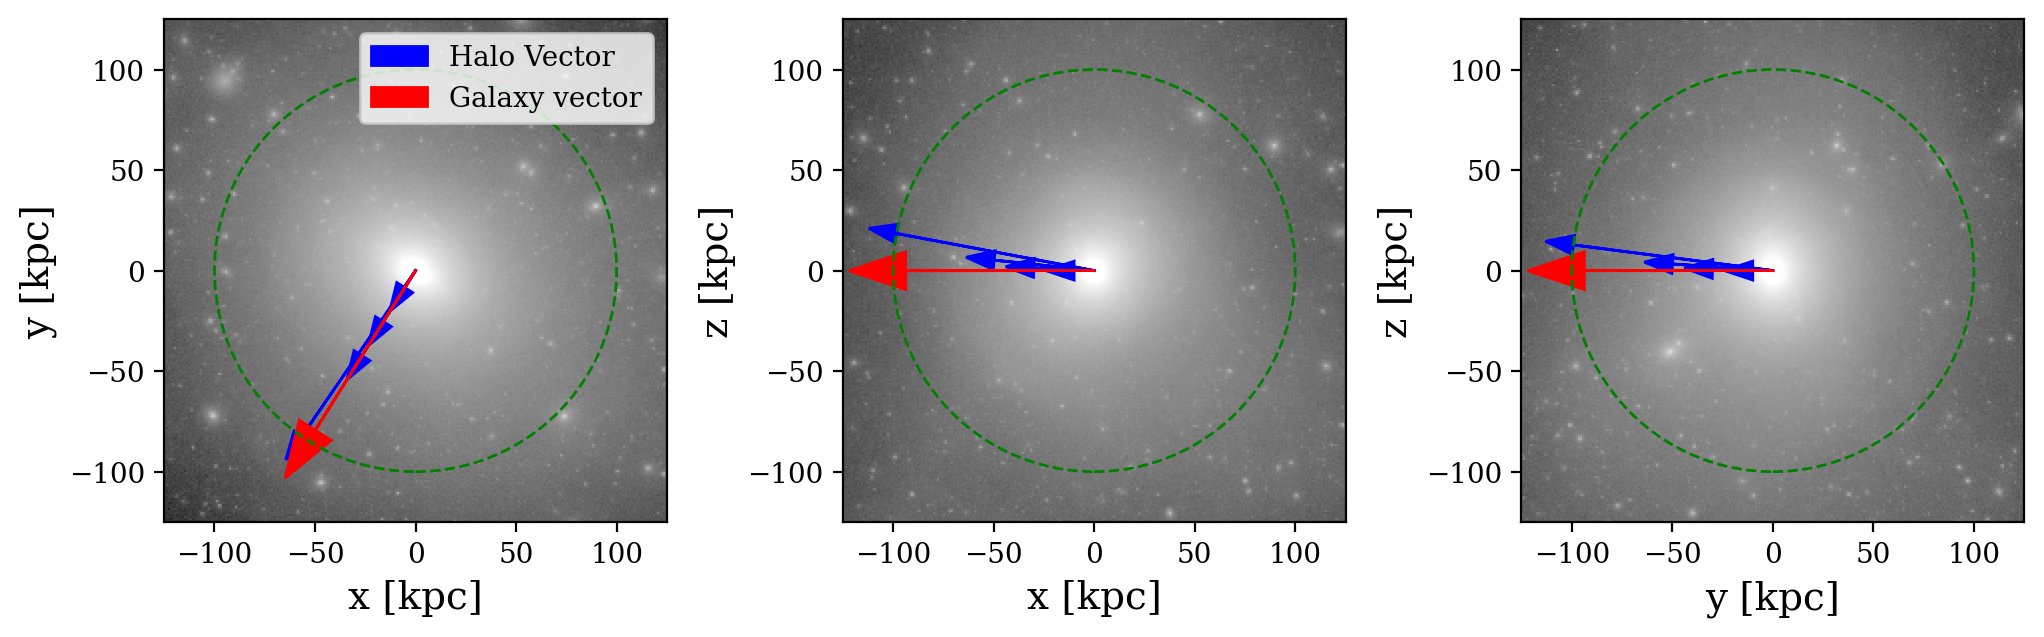

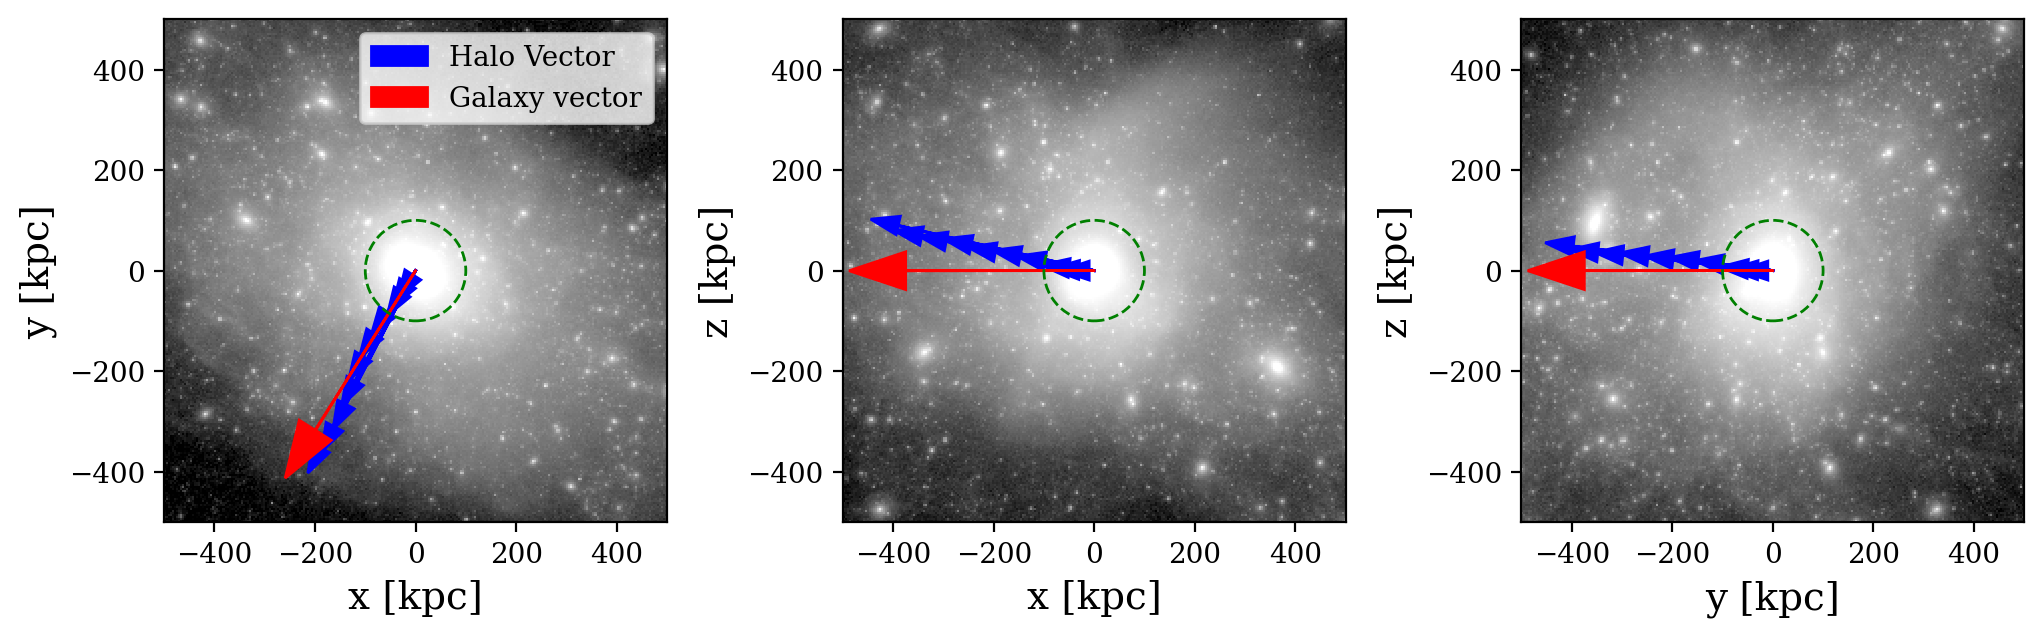

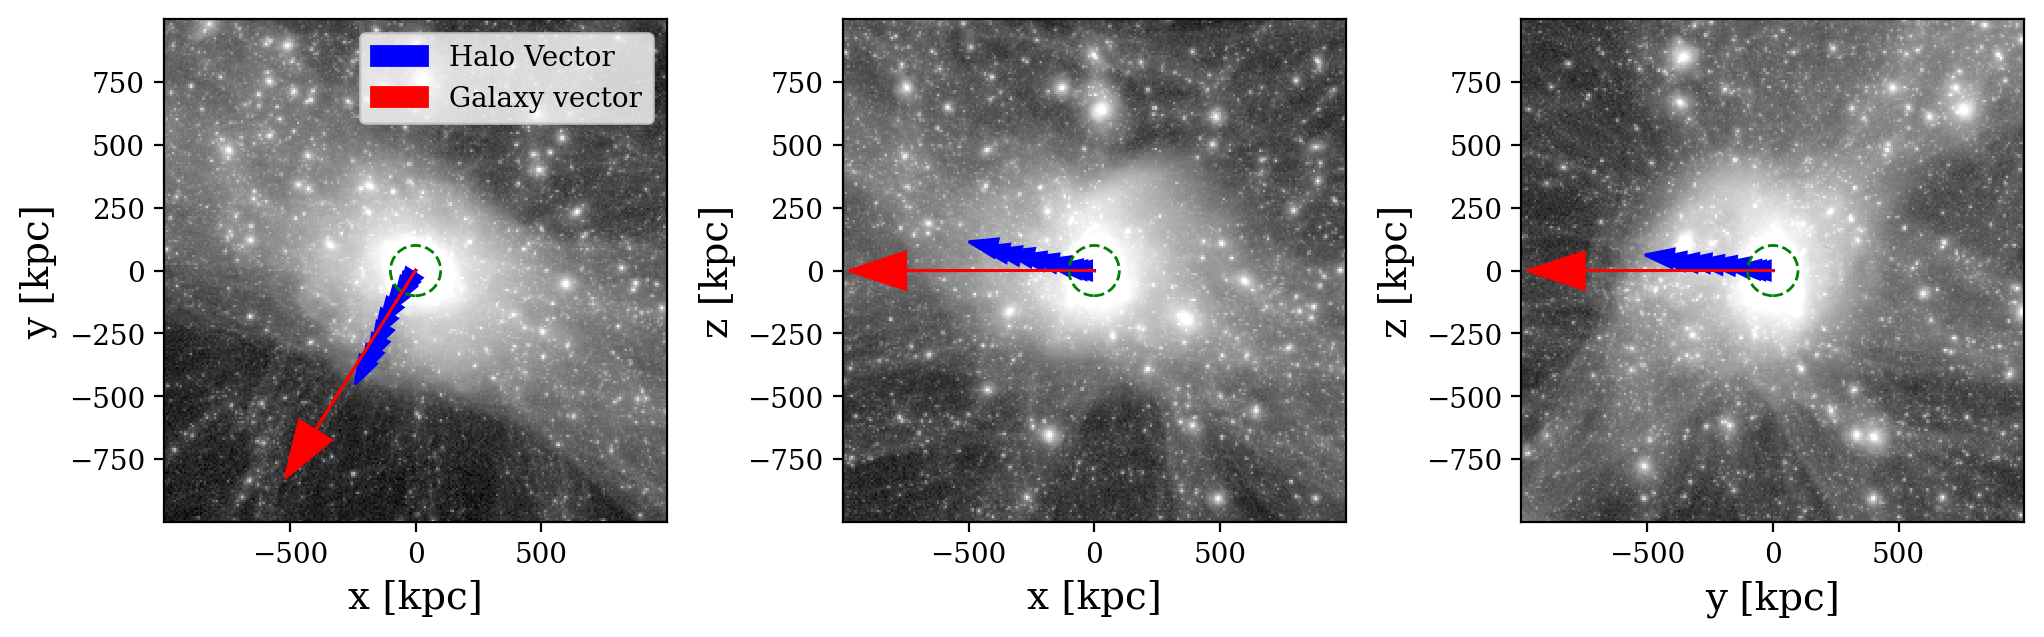

In [5]:
%%time

pos_dark = part["dark"].prop("host.distance")

host_minor_ax = part.host["rotation"][0, 2]

scales = [125, 500, 1000]

for scale in scales:
    k = .75 * scale

    bins = 250
    vmax = 10000
    vmin = 10

    xym = (abs(pos_dark[:, 0]) < scale) & (abs(pos_dark[:, 1]) < scale)
    xzm = (abs(pos_dark[:, 0]) < scale) & (abs(pos_dark[:, 2]) < scale)
    yzm = (abs(pos_dark[:, 1]) < scale) & (abs(pos_dark[:, 2]) < scale)

    fig, axs = plt.subplots(1,3,figsize=(12,5), dpi=200)

    (xy, xz, yz) = axs

    # plot DM particles 
    xy.hist2d(
        pos_dark[:, 0][xym],
        pos_dark[:, 1][xym],
        bins=bins,
        norm=colors.LogNorm(vmin=vmin, vmax=vmax),
        cmap="binary_r"
    )

    xz.hist2d(
        pos_dark[:, 0][xzm],
        pos_dark[:, 2][xzm],
        bins=bins,
        norm=colors.LogNorm(vmin=vmin, vmax=vmax),
        cmap="binary_r"
    )

    yz.hist2d(
        pos_dark[:, 1][yzm],
        pos_dark[:, 2][yzm],
        bins=bins,
        norm=colors.LogNorm(vmin=vmin, vmax=vmax),
        cmap="binary_r"
    )

    # show the halo vector

    for i, radius in enumerate(r):
        if radius <= scale:
            arrow_scale = radius
            if i == 0:
                xy.arrow(
                0, 0,
                arrow_scale*np.array(min_axs_corrected[i, 0]) / np.linalg.norm([min_axs_corrected[i, 0], min_axs_corrected[i, 1]]),
                arrow_scale*np.array(min_axs_corrected[i, 1]) / np.linalg.norm([min_axs_corrected[i, 0], min_axs_corrected[i, 1]]),
                color='b',
                label="Halo Vector",
                head_width=k/10
            )
            else:
                xy.arrow(
                    0, 0,
                    arrow_scale*np.array(min_axs_corrected[i, 0]) / np.linalg.norm([min_axs_corrected[i, 0], min_axs_corrected[i, 1]]),
                    arrow_scale*np.array(min_axs_corrected[i, 1]) / np.linalg.norm([min_axs_corrected[i, 0], min_axs_corrected[i, 1]]),
                    color='b',
                    head_width=k/10
                )

            xz.arrow(
                0, 0,
                arrow_scale*np.array(min_axs_corrected[i, 0]) / np.linalg.norm([min_axs_corrected[i, 0], min_axs_corrected[i, 2]]),
                arrow_scale*np.array(min_axs_corrected[i, 2]) / np.linalg.norm([min_axs_corrected[i, 0], min_axs_corrected[i, 2]]),
                color='b',
                head_width=k/10
            )

            yz.arrow(
                0, 0,
                arrow_scale*np.array(min_axs_corrected[i, 1]) / np.linalg.norm([min_axs_corrected[i, 1], min_axs_corrected[i, 2]]),
                arrow_scale*np.array(min_axs_corrected[i, 2]) / np.linalg.norm([min_axs_corrected[i, 1], min_axs_corrected[i, 2]]),
                color='b',
                head_width=k/10
            )

    # show the galaxy vector
    xy.arrow(
        0, 0,
        k*host_minor_ax[0] / np.linalg.norm([host_minor_ax[0], host_minor_ax[1]]),
        k*host_minor_ax[1] / np.linalg.norm([host_minor_ax[0], host_minor_ax[1]]),
        color='r',
        label="Galaxy vector",
        head_width=k/5
    )

    xz.arrow(
        0, 0,
        k*host_minor_ax[0] / np.linalg.norm([host_minor_ax[0], host_minor_ax[2]]),
        k*host_minor_ax[2] / np.linalg.norm([host_minor_ax[0], host_minor_ax[2]]),
        color='r',
        head_width=k/5
    )

    yz.arrow(
        0, 0,
        k*host_minor_ax[1] / np.linalg.norm([host_minor_ax[1], host_minor_ax[2]]),
        k*host_minor_ax[2] / np.linalg.norm([host_minor_ax[1], host_minor_ax[2]]),
        color='r',
        head_width=k/5
    )

    xy.set_aspect(1)
    xz.set_aspect(1)
    yz.set_aspect(1)

    xy.set_xlabel("x [kpc]", size=14)
    xz.set_xlabel("x [kpc]", size=14)
    yz.set_xlabel("y [kpc]", size=14)

    xy.set_ylabel("y [kpc]", size=14)
    xz.set_ylabel("z [kpc]", size=14)
    yz.set_ylabel("z [kpc]", size=14)

    circle1 = plt.Circle((0, 0), 100, ec='green', ls='--', fc='None')
    circle2 = plt.Circle((0, 0), 100, ec='green', ls='--', fc='None')
    circle3 = plt.Circle((0, 0), 100, ec='green', ls='--', fc='None')
    xy.add_patch(circle1)
    xz.add_patch(circle2)
    yz.add_patch(circle3)

    xy.legend()

    fig.subplots_adjust(wspace=.35)

    plt.savefig(f"{sim_name[:4]}_density_{scale}.png", bbox_inches="tight")

with circles